### Comparing Online Portfolio Management Algorithms using the Experiments of Agarwal et al. 2007
- In this notebook we analyze the performance of several online portfolio management algorithms using the 'universal-portfolios' package available in Python 
- Our experiments mirror those found in Newton Method Based portfolio management 
- There are two major categories of algorithm under examination: 'Follow the Winner' algorithms, and 'Follow the Loser'
    - Follow the Winner: UP, EG, ONS
    - Follow the Loser: PAMR, CWMR, OLMAR, RMR 
- Benchmark algorithms that we compare performance against are the UCRP, and BCRP
- Extensions: Running more algorithms (Pattern-matching Algorithms)

In [1]:
%matplotlib inline
from __future__ import division
import pandas as pd 
import numpy as np

from universal import tools
from universal import algos
import logging
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.DEBUG)

from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

C:\Users\Josh\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# note what versions we are on:
import sys
print('Python: '+sys.version)
print('Pandas: '+pd.__version__)
import pkg_resources
print('universal-portfolios: '+pkg_resources.get_distribution("universal-portfolios").version)

Python: 2.7.14 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:34:40) [MSC v.1500 64 bit (AMD64)]
Pandas: 0.21.0
universal-portfolios: 0.3.2


#### Data Preprocessing 

In [3]:
date_conv = lambda x: pd.to_datetime(x)

def data_reader(tickers, source, start_date, end_date = None):
    '''
    function that reads data from yahoo finance/ quandl data sources
    inputs:
    tickers -- stock tickers
    source -- 'quandl', 'yahoo'
    start_date -- start of pricing information
    end_date -- end of pricing information 
    returns:
    '''
    data = DataReader(tickers, source, start_date, end_date)
    return data 

def tradable_stocks():
    '''
    List of S&P500 stocks that contain a 30 year price history 
    '''
    return ['AAPL','ABT','AET','ARNC','AXP','BAC','BCR','BDX','CI','CLX','CMC','CMI','CRS','CSX','DIS','DUK','EMR',
            'FDX','GE','GIS','GPC','HON','HPQ','IBM','IFF','INTC','KO','LLY','LNC','MCD','MEI','NEE','NEM','SHW','SLB',
            'TAP','TGT','TXT','WFC','WMB'
           ]

def tradable_csvs():
    '''
    List of S&P500 csv files available. All stocks contain a 30 year price history. This allows one to avoid API call limits
    '''
    return ['AAPL.csv','ABT.csv','AET.csv','ARNC.csv','AXP.csv','BAC.csv','BCR.csv','BDX.csv','CI.csv','CLX.csv','CMC.csv',
            'CMI.csv','CRS.csv','CSX.csv','DIS.csv','DUK.csv','EMR.csv','FDX.csv','GE.csv','GIS.csv','GPC.csv','HON.csv',
            'HPQ.csv','IBM.csv','IFF.csv','INTC.csv','KO.csv','LLY.csv','LNC.csv','MCD.csv','MEI.csv','NEE.csv','NEM.csv','SHW.csv',
            'SLB.csv','TAP.csv','TGT.csv','TXT.csv','WFC.csv','WMB.csv'
           ]

def stock_df(n_stocks, start_date, end_date, csv = None):
    '''
    function that takes as input a portolio size n and returns a dataframe that contains a number of stocks  
    '''
    # select n stock csv files 
    if csv != None:
        filenames = csv
    else:
        filenames = tradable_csvs()[0:n_stocks]
    # construct empty data frame to hold financial data
    ret_df = pd.DataFrame()
    price_df = pd.DataFrame()
    for f in filenames:
        series = pd.read_csv('C://Users//Josh//Desktop//ACTSC972_project//data//' + f)
        series['Date'] = series['Date'].apply(date_conv)
        series = series.set_index('Date')
        series = series['Adj Close']
        series = series.loc[(series.index<=end_date) & (series.index >= start_date)].astype('float')
        series_ret = series.iloc[0:-1].as_matrix()/series.iloc[1:].as_matrix()
        ret_df[f.split('.')[0]] = series_ret
        price_df[f.split('.')[0]] = series
    return ret_df, price_df  

In [4]:
# construct data frame that contains returns data for 40 stocks 
n = 40
start_date = pd.to_datetime('2010-01-10')
end_date = pd.to_datetime('2017-09-20')
returns_df, price_df = stock_df(n, start_date, end_date)

In [5]:
returns_df.head()

,AAPL,ABT,AET,ARNC,AXP,BAC,BCR,BDX,CI,CLX,...,MEI,NEE,NEM,SHW,SLB,TAP,TGT,TXT,WFC,WMB
0,1.011506,1.002900,1.069585,1.124355,0.986911,1.034841,1.009943,1.015016,1.022715,0.998535,...,1.009804,1.024941,1.034213,1.003534,1.015233,0.996458,1.017025,1.006563,1.025641,1.030262
1,0.986091,0.990595,0.995447,0.971214,0.996916,0.984356,0.973738,0.996774,1.002469,0.991927,...,0.972045,0.996505,0.995282,0.987371,0.982216,0.996031,1.000000,1.019599,0.982505,0.999084
2,1.005825,0.998916,0.978988,1.010752,0.987582,0.988109,0.988988,1.005971,0.991297,1.000646,...,1.016234,1.029794,1.006815,0.994218,0.993828,0.994736,0.984830,0.917947,0.985857,1.005991
3,1.016996,0.997477,1.001595,1.011517,1.006841,1.034440,1.011256,1.009831,0.998100,1.011440,...,1.027523,0.989317,1.017013,1.022639,1.006494,1.009075,0.998605,1.041591,1.032407,1.015442
4,0.957636,0.987367,0.960196,1.000640,0.986732,0.996323,0.985566,0.987062,0.971519,0.995283,...,0.996675,0.993319,0.982866,0.996968,0.998590,1.013459,0.979882,0.952132,0.992928,0.925108


In [6]:
price_df.head()

,AAPL,ABT,AET,ARNC,AXP,BAC,BCR,BDX,CI,CLX,...,MEI,NEE,NEM,SHW,SLB,TAP,TGT,TXT,WFC,WMB
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-11,27.003820,21.532736,30.029846,36.411705,36.933857,15.913613,77.263260,67.476524,37.181705,48.520897,...,10.687086,40.495270,44.774933,53.846889,60.504143,37.448517,40.794662,21.023281,23.909105,12.995709
2010-01-12,26.696650,21.470472,28.076166,32.384525,37.423706,15.377831,76.502563,66.478264,36.355896,48.592091,...,10.583330,39.509838,43.293732,53.657272,59.596336,37.581631,40.111771,20.886204,23.311371,12.613988
2010-01-13,27.073221,21.674320,28.204578,33.344368,37.539482,15.622222,78.565857,66.693405,36.266354,48.987583,...,10.887694,39.648411,43.498966,54.343559,60.675404,37.731388,40.111771,20.484732,23.726467,12.625559
2010-01-14,26.916422,21.697838,28.809944,32.989651,38.011509,15.810215,79.440628,66.297562,36.584740,48.955956,...,10.713769,38.501308,43.204514,54.659615,61.052204,37.931072,40.729626,22.315823,24.066833,12.550372
2010-01-15,26.466595,21.752720,28.764076,32.614048,37.753227,15.283833,78.556381,65.652153,36.654381,48.402237,...,10.426793,38.917042,42.481766,53.449577,60.658264,37.589947,40.786522,21.424755,23.311371,12.359512


Text(0.5,1,u'Daily Stock Returns')

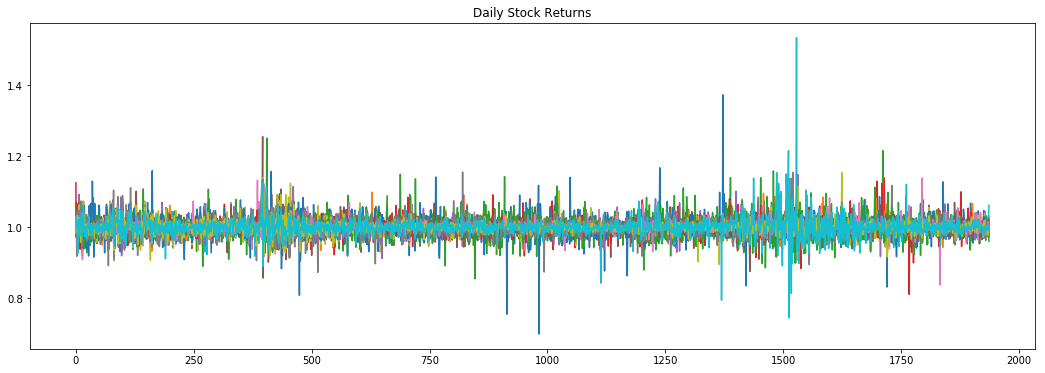

In [7]:
returns_df.plot(figsize=(18,6), legend = False)
plt.title('Daily Stock Returns')

Text(0.5,1,u'Adjusted Closing Price')

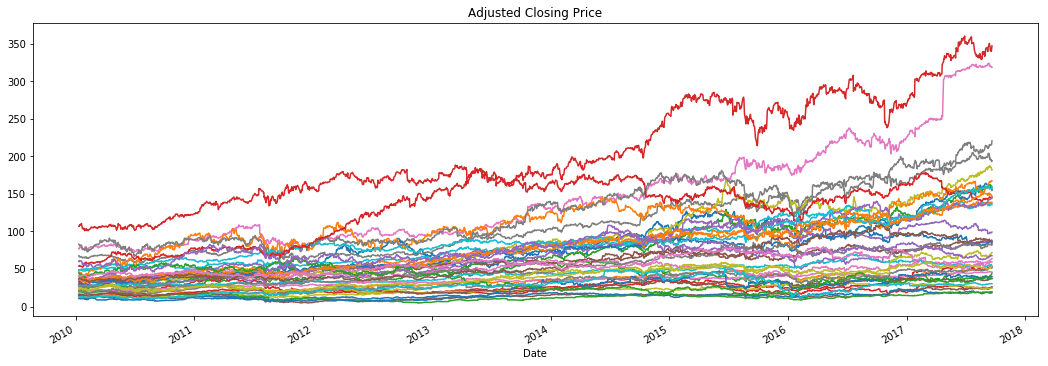

In [8]:
price_df.plot(figsize = (18,6), legend = False)
plt.title('Adjusted Closing Price')

In [9]:
# stocks in data frame
price_df.columns

Index([u'AAPL', u'ABT', u'AET', u'ARNC', u'AXP', u'BAC', u'BCR', u'BDX', u'CI',
       u'CLX', u'CMC', u'CMI', u'CRS', u'CSX', u'DIS', u'DUK', u'EMR', u'FDX',
       u'GE', u'GIS', u'GPC', u'HON', u'HPQ', u'IBM', u'IFF', u'INTC', u'KO',
       u'LLY', u'LNC', u'MCD', u'MEI', u'NEE', u'NEM', u'SHW', u'SLB', u'TAP',
       u'TGT', u'TXT', u'WFC', u'WMB'],
      dtype='object')

In [10]:
#### Initiate Algorithms for Testing 

algorithms = [
algos.BCRP(),
algos.EG(),
algos.ONS(),
algos.OLMAR(window=5, eps = 10),
algos.PAMR(),
algos.CWMR(),
algos.Anticor()
]

# need to fix bug in code for UP algorithm and BNN algorithm

#### Experiment 1: Mean APY Versus Portfolio Size 

In [11]:
portfolio_size = [10, 15, 20, 25, 30, 35, 40]
algorithms_col = ['BCRP', 'EG', 'ONS', 'OLMAR', 'PAMR', 'CWMR', 'ANTICOR']
exp1_df = pd.DataFrame(data = None, index = portfolio_size, columns = algorithms_col)
#apy = np.zeros((len(portfolio_size), len(algorithms_col)))

In [12]:
exp1_df.head()

,BCRP,EG,ONS,OLMAR,PAMR,CWMR,ANTICOR
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
for i in range(len(algorithms)):
    for j in range(len(portfolio_size)):
        data = returns_df.iloc[:,0:portfolio_size[j]]
        result = algorithms[i].run(data)
        mapy = result.annualized_return/7
        exp1_df.loc[portfolio_size[j], algorithms_col[i]] = mapy

2017-12-09 17:28:34,375 Running BCRP...
2017-12-09 17:28:34,785 BCRP finished successfully.
2017-12-09 17:28:34,813 Running BCRP...
2017-12-09 17:28:34,993 BCRP finished successfully.
2017-12-09 17:28:35,039 Running BCRP...
2017-12-09 17:28:35,322 BCRP finished successfully.
2017-12-09 17:28:35,354 Running BCRP...
2017-12-09 17:28:35,605 BCRP finished successfully.
2017-12-09 17:28:35,641 Running BCRP...
2017-12-09 17:28:36,052 BCRP finished successfully.
2017-12-09 17:28:36,096 Running BCRP...
2017-12-09 17:28:36,420 BCRP finished successfully.
2017-12-09 17:28:36,461 Running BCRP...
2017-12-09 17:28:36,861 BCRP finished successfully.
2017-12-09 17:28:37,013 Running EG...
2017-12-09 17:28:37,028 Progress: 0%...
2017-12-09 17:28:37,335 Progress: 10%...
2017-12-09 17:28:37,607 Progress: 20%...
2017-12-09 17:28:37,905 Progress: 30%...
2017-12-09 17:28:38,187 Progress: 40%...
2017-12-09 17:28:38,469 Progress: 50%...
2017-12-09 17:28:38,753 Progress: 60%...
2017-12-09 17:28:39,115 Progress

2017-12-09 17:30:59,086 Progress: 30%...
2017-12-09 17:30:59,578 Progress: 40%...
2017-12-09 17:31:00,079 Progress: 50%...
2017-12-09 17:31:00,601 Progress: 60%...
2017-12-09 17:31:01,098 Progress: 70%...
2017-12-09 17:31:01,621 Progress: 80%...
2017-12-09 17:31:02,263 Progress: 90%...
2017-12-09 17:31:02,828 OLMAR finished successfully.
2017-12-09 17:31:02,861 Running OLMAR...
2017-12-09 17:31:03,413 Progress: 10%...
2017-12-09 17:31:03,964 Progress: 20%...
2017-12-09 17:31:04,608 Progress: 30%...
2017-12-09 17:31:05,229 Progress: 40%...
2017-12-09 17:31:05,805 Progress: 50%...
2017-12-09 17:31:06,259 Progress: 60%...
2017-12-09 17:31:06,727 Progress: 70%...
2017-12-09 17:31:07,197 Progress: 80%...
2017-12-09 17:31:07,654 Progress: 90%...
2017-12-09 17:31:08,102 OLMAR finished successfully.
2017-12-09 17:31:08,131 Running OLMAR...
2017-12-09 17:31:08,605 Progress: 10%...
2017-12-09 17:31:09,072 Progress: 20%...
2017-12-09 17:31:09,548 Progress: 30%...
2017-12-09 17:31:10,009 Progress:

2017-12-09 17:32:06,309 Progress: 0%...
2017-12-09 17:32:07,220 Progress: 10%...
2017-12-09 17:32:08,124 Progress: 20%...
2017-12-09 17:32:09,095 Progress: 30%...
2017-12-09 17:32:09,996 Progress: 40%...
2017-12-09 17:32:10,901 Progress: 50%...
2017-12-09 17:32:11,811 Progress: 60%...
2017-12-09 17:32:12,776 Progress: 70%...
2017-12-09 17:32:13,691 Progress: 80%...
2017-12-09 17:32:14,578 Progress: 90%...
2017-12-09 17:32:15,569 CWMR finished successfully.
2017-12-09 17:32:15,601 Running CWMR...
2017-12-09 17:32:15,638 Progress: 0%...
2017-12-09 17:32:16,447 Progress: 10%...
2017-12-09 17:32:17,259 Progress: 20%...
2017-12-09 17:32:18,084 Progress: 30%...
2017-12-09 17:32:18,907 Progress: 40%...
2017-12-09 17:32:19,733 Progress: 50%...
2017-12-09 17:32:20,552 Progress: 60%...
2017-12-09 17:32:21,359 Progress: 70%...
2017-12-09 17:32:22,184 Progress: 80%...
2017-12-09 17:32:22,984 Progress: 90%...
2017-12-09 17:32:23,796 CWMR finished successfully.
2017-12-09 17:32:23,835 Running CWMR..

In [14]:
exp1_df

,BCRP,EG,ONS,OLMAR,PAMR,CWMR,ANTICOR
10,0.00572419,0.00448941,0.0340166,9.46092,3.87348,3.86222,0.316522
15,0.00698669,0.00530883,0.0522966,26.034,8.02215,8.05124,0.490428
20,0.00705004,0.00487419,0.059677,35.7136,10.3159,10.3252,0.523029
25,0.00765715,0.00472466,0.065728,48.4592,12.4242,12.4498,0.553004
30,0.00766612,0.00467679,0.0760265,61.1932,15.2713,15.2939,0.545103
35,0.0132903,0.00556554,0.0854724,182.613,33.4107,33.8116,0.644191
40,0.0151103,0.00588506,0.100067,320.373,49.3127,49.7297,0.702001


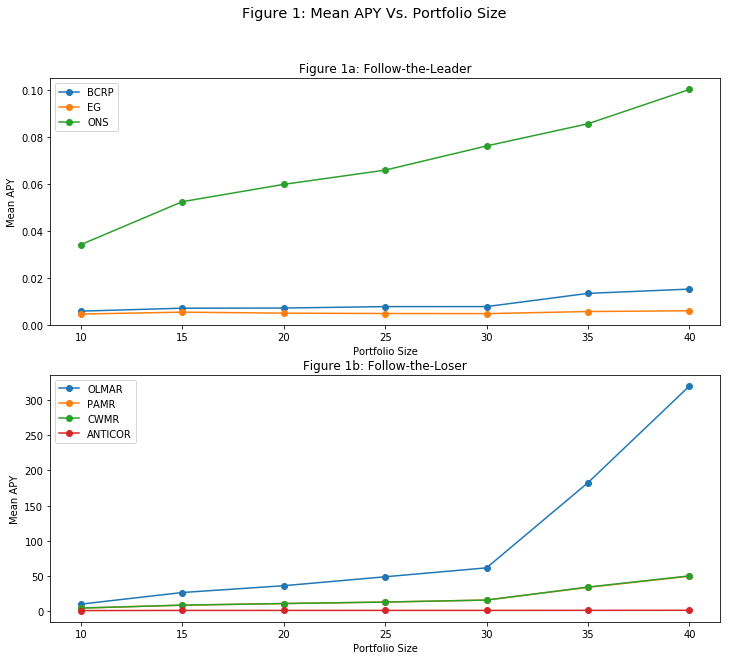

In [15]:
plt.figure(figsize = (12,10))
plt.suptitle('Figure 1: Mean APY Vs. Portfolio Size', fontsize="x-large")
plt.subplot(2,1,1)
plt.plot(portfolio_size, exp1_df['BCRP'], '-o')
plt.plot(portfolio_size, exp1_df['EG'], '-o')
plt.plot(portfolio_size, exp1_df['ONS'], '-o')
plt.title('Figure 1a: Follow-the-Leader')
plt.legend(['BCRP', 'EG', 'ONS'])
plt.xlabel('Portfolio Size')
plt.ylabel('Mean APY')
plt.subplot(2,1,2)
plt.plot(portfolio_size, exp1_df['OLMAR'], '-o')
plt.plot(portfolio_size, exp1_df['PAMR'], '-o')
plt.plot(portfolio_size, exp1_df['CWMR'], '-o')
plt.plot(portfolio_size, exp1_df['ANTICOR'], '-o')
plt.legend(['OLMAR', 'PAMR', 'CWMR', 'ANTICOR'])
plt.xlabel('Portfolio Size')
plt.ylabel('Mean APY')
plt.title('Figure 1b: Follow-the-Loser')
plt.show()
plt.show()

#### Experiment 2: Total Wealth Achieved in a 10 Stock Portfolio 

In [16]:
n_stock = 10
return2_df, price2_df = stock_df(n_stock,start_date, end_date)

Text(0.5,1,u'Figure 2: 10 Stock Portfolio')

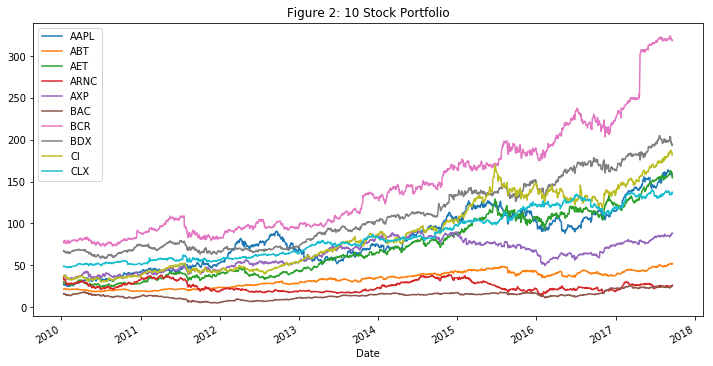

In [17]:
price2_df.plot(figsize = (12,6))
plt.title('Figure 2: 10 Stock Portfolio')

In [18]:
price2_df.columns

Index([u'AAPL', u'ABT', u'AET', u'ARNC', u'AXP', u'BAC', u'BCR', u'BDX', u'CI',
       u'CLX'],
      dtype='object')

In [19]:
metrics = ['results', 
           'profit', 
           'sharpe', 
           'information_ratio', 
           'annualized_return', 
           'drawdown', 
           'win_pct']

In [20]:
exp2_df = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)

In [21]:
exp2_df

,results,profit,sharpe,information_ratio,annualized_return,drawdown,win_pct
BCRP,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OLMAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAMR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CWMR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANTICOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# run each algorithm on data set 
for i in range(len(algorithms_col)):
    exp2_df.loc[algorithms_col[i], 'results'] = algorithms[i].run(return2_df)

2017-12-09 17:33:28,859 Running BCRP...
2017-12-09 17:33:28,957 BCRP finished successfully.
2017-12-09 17:33:28,984 Running EG...
2017-12-09 17:33:29,000 Progress: 0%...
2017-12-09 17:33:29,311 Progress: 10%...
2017-12-09 17:33:29,599 Progress: 20%...
2017-12-09 17:33:29,888 Progress: 30%...
2017-12-09 17:33:30,157 Progress: 40%...
2017-12-09 17:33:30,421 Progress: 50%...
2017-12-09 17:33:30,696 Progress: 60%...
2017-12-09 17:33:30,957 Progress: 70%...
2017-12-09 17:33:31,246 Progress: 80%...
2017-12-09 17:33:31,515 Progress: 90%...
2017-12-09 17:33:31,786 EG finished successfully.
2017-12-09 17:33:31,809 Running ONS...
2017-12-09 17:33:31,832 Progress: 0%...
2017-12-09 17:33:32,779 Progress: 10%...
2017-12-09 17:33:33,589 Progress: 20%...
2017-12-09 17:33:34,305 Progress: 30%...
2017-12-09 17:33:35,154 Progress: 40%...
2017-12-09 17:33:35,977 Progress: 50%...
2017-12-09 17:33:36,825 Progress: 60%...
2017-12-09 17:33:37,759 Progress: 70%...
2017-12-09 17:33:38,713 Progress: 80%...
2017

In [23]:
def statistics(exp_df):
    '''
    Function that takes as input an experiment data frame and unpacks the results for each algorithm into their 
    respective columns
    '''
    for ind in exp_df.index:
        exp_df.loc[ind, 'profit'] = exp_df.loc[ind, 'results'].profit_factor
        exp_df.loc[ind, 'sharpe'] = exp_df.loc[ind, 'results'].sharpe
        exp_df.loc[ind, 'information_ratio'] = exp_df.loc[ind, 'results'].information
        exp_df.loc[ind, 'annualized_return'] = exp_df.loc[ind, 'results'].annualized_return
        exp_df.loc[ind, 'drawdown'] = exp_df.loc[ind, 'results'].max_drawdown
        exp_df.loc[ind, 'win_pct'] = exp_df.loc[ind, 'results'].winning_pct
    return exp_df

In [24]:
exp2_df = statistics(exp2_df)

In [25]:
def results_plot(exp_df, title, sub_title, figsize):
    '''
    Function that takes as input a data frame of results and produces a 6 panel image containing histograms for the following:
    profit factor, sharpe ratio, information ratio, annualized return, maximum drawdown, and win percentage
    inputs:
    exp_df -- data frame containing experimental results
    title -- main title of image
    sub_title -- titles of subplots (ordered)
    figsize -- size of output image
    '''
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = figsize)
    f.suptitle(title)
    axs = [ax1, ax2, ax3, ax4, ax5, ax6]
    for i in range(len(axs)):
        axs[i].bar(exp_df.index, exp_df.iloc[:,i+1], width = 1.0, color = sns.light_palette("navy", reverse=True))
        axs[i].set_title(sub_title[i])
    plt.show()

In [26]:
exp2_df

,results,profit,sharpe,information_ratio,annualized_return,drawdown,win_pct
BCRP,<universal.result.AlgoResult object at 0x00000...,1.02515,0.140336,0.0682201,0.0400693,0.17381,0.516012
EG,<universal.result.AlgoResult object at 0x00000...,1.02333,0.131528,-4.34791,0.0314259,0.137012,0.518595
ONS,<universal.result.AlgoResult object at 0x00000...,1.17351,0.920246,4.26829,0.238116,0.113453,0.541839
OLMAR,<universal.result.AlgoResult object at 0x00000...,7.13521,10.3943,13.7817,66.2265,0.102574,0.77531
PAMR,<universal.result.AlgoResult object at 0x00000...,4.32666,7.77548,10.364,27.1144,0.165371,0.729855
CWMR,<universal.result.AlgoResult object at 0x00000...,4.31174,7.77818,10.3597,27.0356,0.165293,0.730372
ANTICOR,<universal.result.AlgoResult object at 0x00000...,2.03345,4.03663,6.0393,2.21565,0.0822555,0.622417


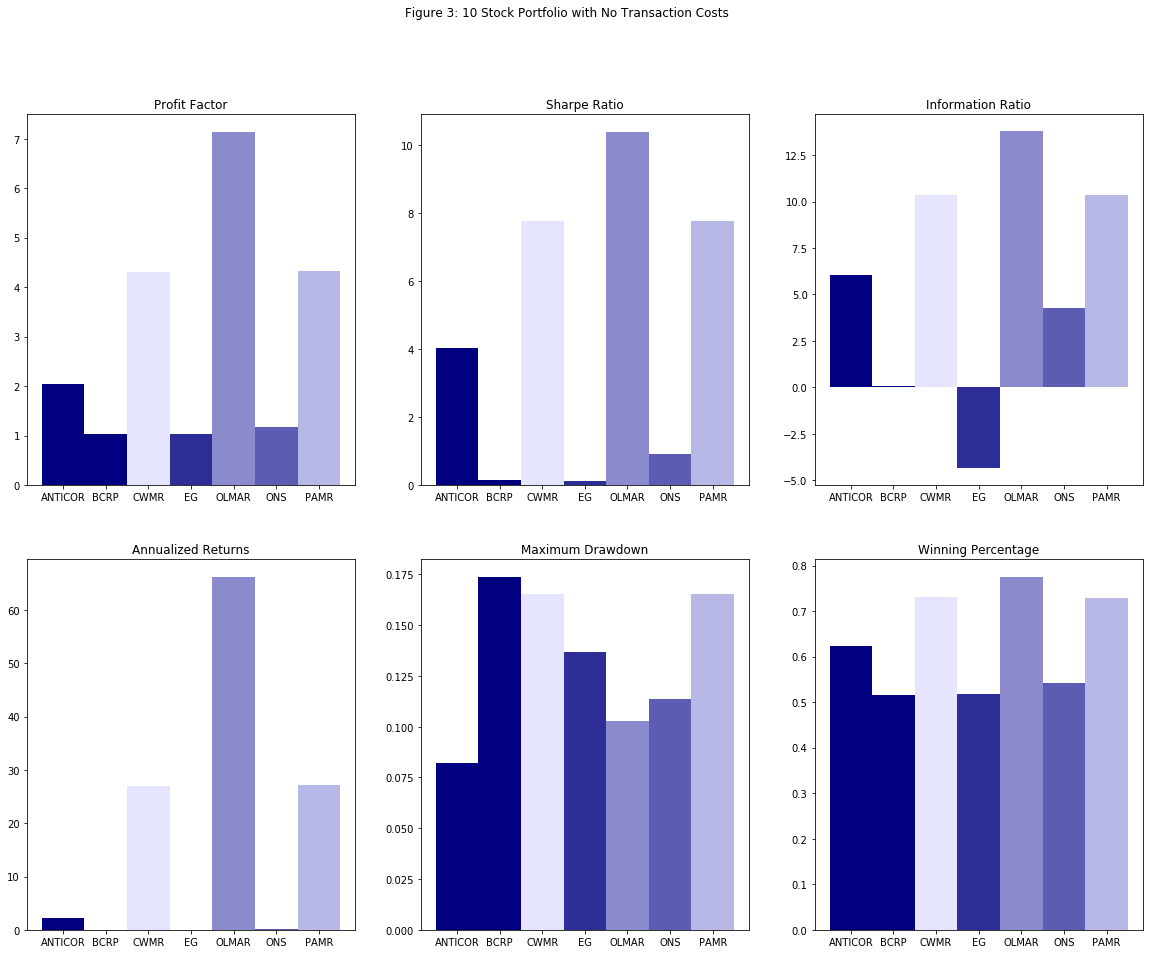

In [27]:
title = 'Figure 3: 10 Stock Portfolio with No Transaction Costs'
sub_title = ['Profit Factor', 
             'Sharpe Ratio', 
             'Information Ratio', 
             'Annualized Returns', 
             'Maximum Drawdown',
            'Winning Percentage']
results_plot(exp2_df, title = title, sub_title = sub_title, figsize = (20,15))

#### Experiment 3: Monthly Trading 

In [28]:
# will need monthly returns in experiment 3
monthly_return = return2_df
monthly_return.index = price2_df.index[:-1]
monthly_return = monthly_return.resample('MS').mean()

In [29]:
monthly_results = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)

In [30]:
# run each algorithm on data set 
for i in range(len(algorithms_col)):
    monthly_results.loc[algorithms_col[i], 'results'] = algorithms[i].run(monthly_return)

2017-12-09 17:33:56,075 Running BCRP...
2017-12-09 17:33:56,209 BCRP finished successfully.
2017-12-09 17:33:56,220 Running EG...
2017-12-09 17:33:56,236 Progress: 0%...
2017-12-09 17:33:56,262 Progress: 10%...
2017-12-09 17:33:56,293 Progress: 20%...
2017-12-09 17:33:56,318 Progress: 30%...
2017-12-09 17:33:56,348 Progress: 40%...
2017-12-09 17:33:56,369 Progress: 50%...
2017-12-09 17:33:56,395 Progress: 60%...
2017-12-09 17:33:56,421 Progress: 70%...
2017-12-09 17:33:56,447 Progress: 80%...
2017-12-09 17:33:56,470 Progress: 90%...
2017-12-09 17:33:56,496 EG finished successfully.
2017-12-09 17:33:56,516 Running ONS...
2017-12-09 17:33:56,538 Progress: 0%...
2017-12-09 17:33:56,618 Progress: 10%...
2017-12-09 17:33:56,694 Progress: 20%...
2017-12-09 17:33:56,769 Progress: 30%...
2017-12-09 17:33:56,834 Progress: 40%...
2017-12-09 17:33:56,894 Progress: 50%...
2017-12-09 17:33:56,953 Progress: 60%...
2017-12-09 17:33:57,019 Progress: 70%...
2017-12-09 17:33:57,078 Progress: 80%...
2017

In [31]:
monthly_results = statistics(monthly_results)

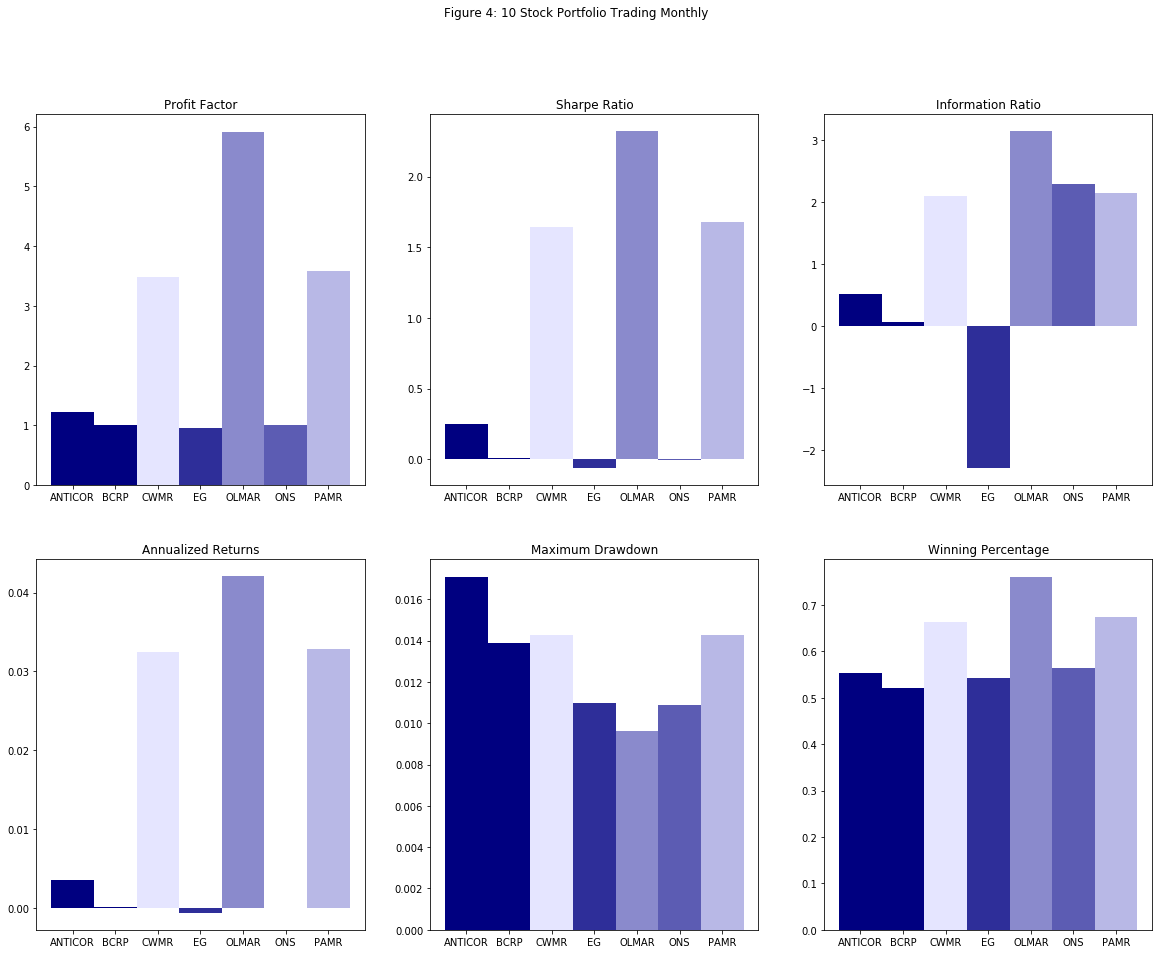

In [60]:
title = 'Figure 4: 10 Stock Portfolio Trading Monthly'
sub_title = ['Profit Factor', 
             'Sharpe Ratio', 
             'Information Ratio', 
             'Annualized Returns', 
             'Maximum Drawdown',
            'Winning Percentage']
results_plot(monthly_results, title = title, sub_title = sub_title, figsize = (20,15))

#### Experiment 4: 10 Stocks with Transaction Costs 

In [33]:
# Add fees of 2% per transaction 
for res in exp2_df.results:
    res.fee = 0.01

In [34]:
exp3_df = statistics(exp2_df)

In [35]:
title = 'Figure 5: 10 Stock Portfolio with Transcation Costs'

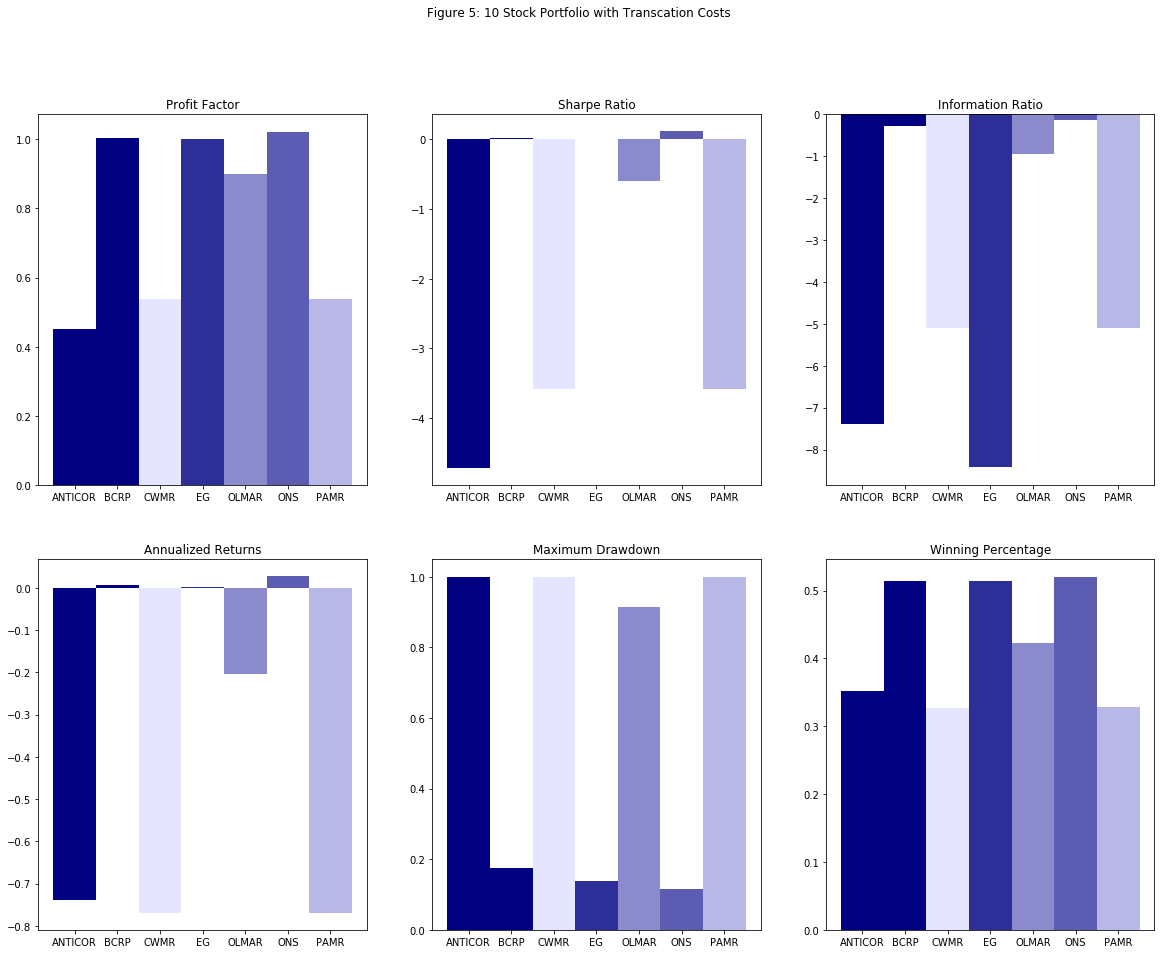

In [36]:
results_plot(exp3_df, title = title, sub_title = sub_title, figsize = (20,15))

#### Experiment 5: Financial Crisis Performance 

In [37]:
n_stocks = 10 
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2011-01-05')
crisis_returns, crisis_prices = stock_df(n_stocks, start_date, end_date)

Text(0.5,1,u'Figure 6: Adjusting Closing Prices During 2008-2009 Financial Crisis')

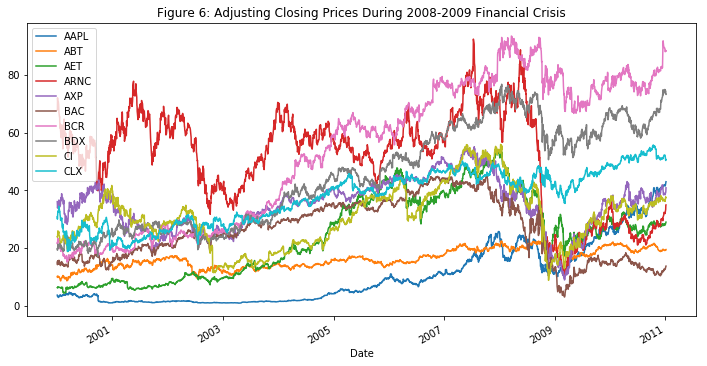

In [38]:
crisis_prices.plot(figsize = (12,6))
plt.title('Figure 6: Adjusting Closing Prices During 2008-2009 Financial Crisis')

In [39]:
exp4_df = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)

In [40]:
# run each algorithm on data set 
for i in range(len(algorithms_col)):
    exp4_df.loc[algorithms_col[i], 'results'] = algorithms[i].run(crisis_returns)

2017-12-09 17:34:13,779 Running BCRP...
2017-12-09 17:34:13,941 BCRP finished successfully.
2017-12-09 17:34:13,966 Running EG...
2017-12-09 17:34:13,980 Progress: 0%...
2017-12-09 17:34:14,374 Progress: 10%...
2017-12-09 17:34:14,782 Progress: 20%...
2017-12-09 17:34:15,154 Progress: 30%...
2017-12-09 17:34:15,548 Progress: 40%...
2017-12-09 17:34:15,915 Progress: 50%...
2017-12-09 17:34:16,286 Progress: 60%...
2017-12-09 17:34:16,714 Progress: 70%...
2017-12-09 17:34:17,108 Progress: 80%...
2017-12-09 17:34:17,484 Progress: 90%...
2017-12-09 17:34:17,869 EG finished successfully.
2017-12-09 17:34:17,894 Running ONS...
2017-12-09 17:34:17,917 Progress: 0%...
2017-12-09 17:34:19,144 Progress: 10%...
2017-12-09 17:34:20,664 Progress: 20%...
2017-12-09 17:34:22,105 Progress: 30%...
2017-12-09 17:34:23,766 Progress: 40%...
2017-12-09 17:34:25,473 Progress: 50%...
2017-12-09 17:34:27,276 Progress: 60%...
2017-12-09 17:34:28,954 Progress: 70%...
2017-12-09 17:34:30,542 Progress: 80%...
2017

In [41]:
exp4_df = statistics(exp4_df)

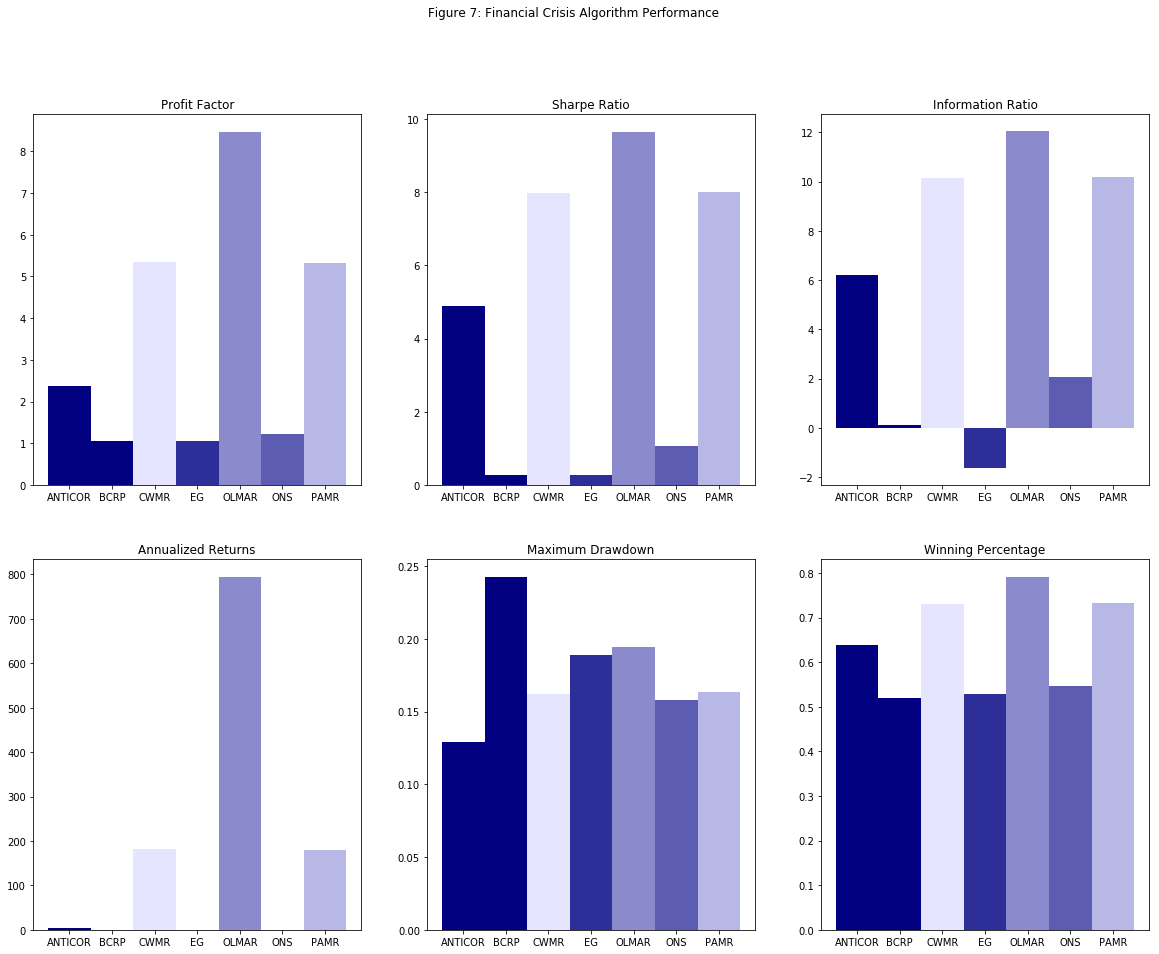

In [42]:
# plot results 
title = 'Figure 7: Financial Crisis Algorithm Performance'
sub_title = ['Profit Factor', 
             'Sharpe Ratio', 
             'Information Ratio', 
             'Annualized Returns', 
             'Maximum Drawdown',
            'Winning Percentage']
figsize = (20,15)
results_plot(exp4_df, title= title, sub_title=sub_title, figsize = (20,15))

#### Experiment 6: Tracking the Best Stock - APPL and IBM 

In [43]:
csvs = ['AAPL.csv', 'IBM.csv' ]
start_date = pd.to_datetime('2010-01-10')
end_date = pd.to_datetime('2017-09-20')
return5_df, price5_df = stock_df(n_stocks = 2, start_date= start_date, end_date = end_date, csv = csvs)

Text(0.5,1,u'Figure 8: AAPL and IBM Stock Performance')

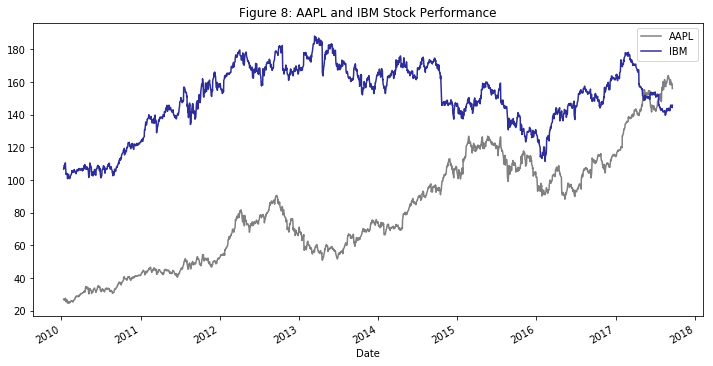

In [44]:
price5_df.plot(color = ['grey', sns.light_palette("navy", reverse=True)[1]] , 
                       figsize = (12,6))
plt.title('Figure 8: AAPL and IBM Stock Performance')

In [45]:
exp5_df = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)

In [46]:
# run algorithm on returns data 
# run each algorithm on data set 
for i in range(len(algorithms_col)):
    exp5_df.loc[algorithms_col[i], 'results'] = algorithms[i].run(return5_df)

2017-12-09 17:34:55,999 Running BCRP...
2017-12-09 17:34:56,013 BCRP finished successfully.
2017-12-09 17:34:56,042 Running EG...
2017-12-09 17:34:56,052 Progress: 0%...
2017-12-09 17:34:56,338 Progress: 10%...
2017-12-09 17:34:56,624 Progress: 20%...
2017-12-09 17:34:56,904 Progress: 30%...
2017-12-09 17:34:57,197 Progress: 40%...
2017-12-09 17:34:57,509 Progress: 50%...
2017-12-09 17:34:57,769 Progress: 60%...
2017-12-09 17:34:58,082 Progress: 70%...
2017-12-09 17:34:58,423 Progress: 80%...
2017-12-09 17:34:58,691 Progress: 90%...
2017-12-09 17:34:59,010 EG finished successfully.
2017-12-09 17:34:59,032 Running ONS...
2017-12-09 17:34:59,052 Progress: 0%...
2017-12-09 17:34:59,717 Progress: 10%...
2017-12-09 17:35:00,122 Progress: 20%...
2017-12-09 17:35:00,582 Progress: 30%...
2017-12-09 17:35:01,262 Progress: 40%...
2017-12-09 17:35:01,704 Progress: 50%...
2017-12-09 17:35:02,108 Progress: 60%...
2017-12-09 17:35:02,625 Progress: 70%...
2017-12-09 17:35:03,101 Progress: 80%...
2017

In [47]:
# # incorporate transcation costs 
# for res in exp5_df.results:
#     res.fee = 0.01

In [48]:
exp5_df = statistics(exp5_df)

In [49]:
def plot_weights(exp_df, best_stock, title, colors, figsize):
    '''
    Function that takes as input a data frame containing experimental results, image title, and image subtitles and returns 
    graphs that display algorithm weights over the backtest period 
    inputs:
    exp_df -- results of experiment
    best_stock -- ticker of the best stock in the experiment 
    title -- main title over image panel
    subtitle -- image subtitles
    legend -- stock tickers
    '''
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize =figsize)
    f.suptitle(title, y = 1.01, fontsize = 14)
    axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
    # plot a common image showing how best stock is tracked 
    for i in range(exp_df.shape[0]):
   #     axs[0].set_color_cycle(sns.light_palette("navy", reverse=True)[1])
        axs[0].plot(exp_df.results[i].equity_decomposed.loc[:,best_stock])
        axs[0].set_xlabel('Trading Days')
        axs[0].set_ylabel('Equity Decomposed')
        axs[0].set_title('Tracking the Best Stock - ' + best_stock)
        axs[0].legend(exp_df.index)
    for i in range(1, len(axs)):
        axs[i].set_color_cycle(colors)
        axs[i].plot(exp_df.results[i-1].equity_decomposed)
        axs[i].set_xlabel('Trading Days')
        axs[i].set_ylabel('Equity Decomposed')
        axs[i].set_title(exp_df.index[i-1])
        axs[i].legend(exp_df.results[0].weights.columns)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

C:\Users\Josh\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


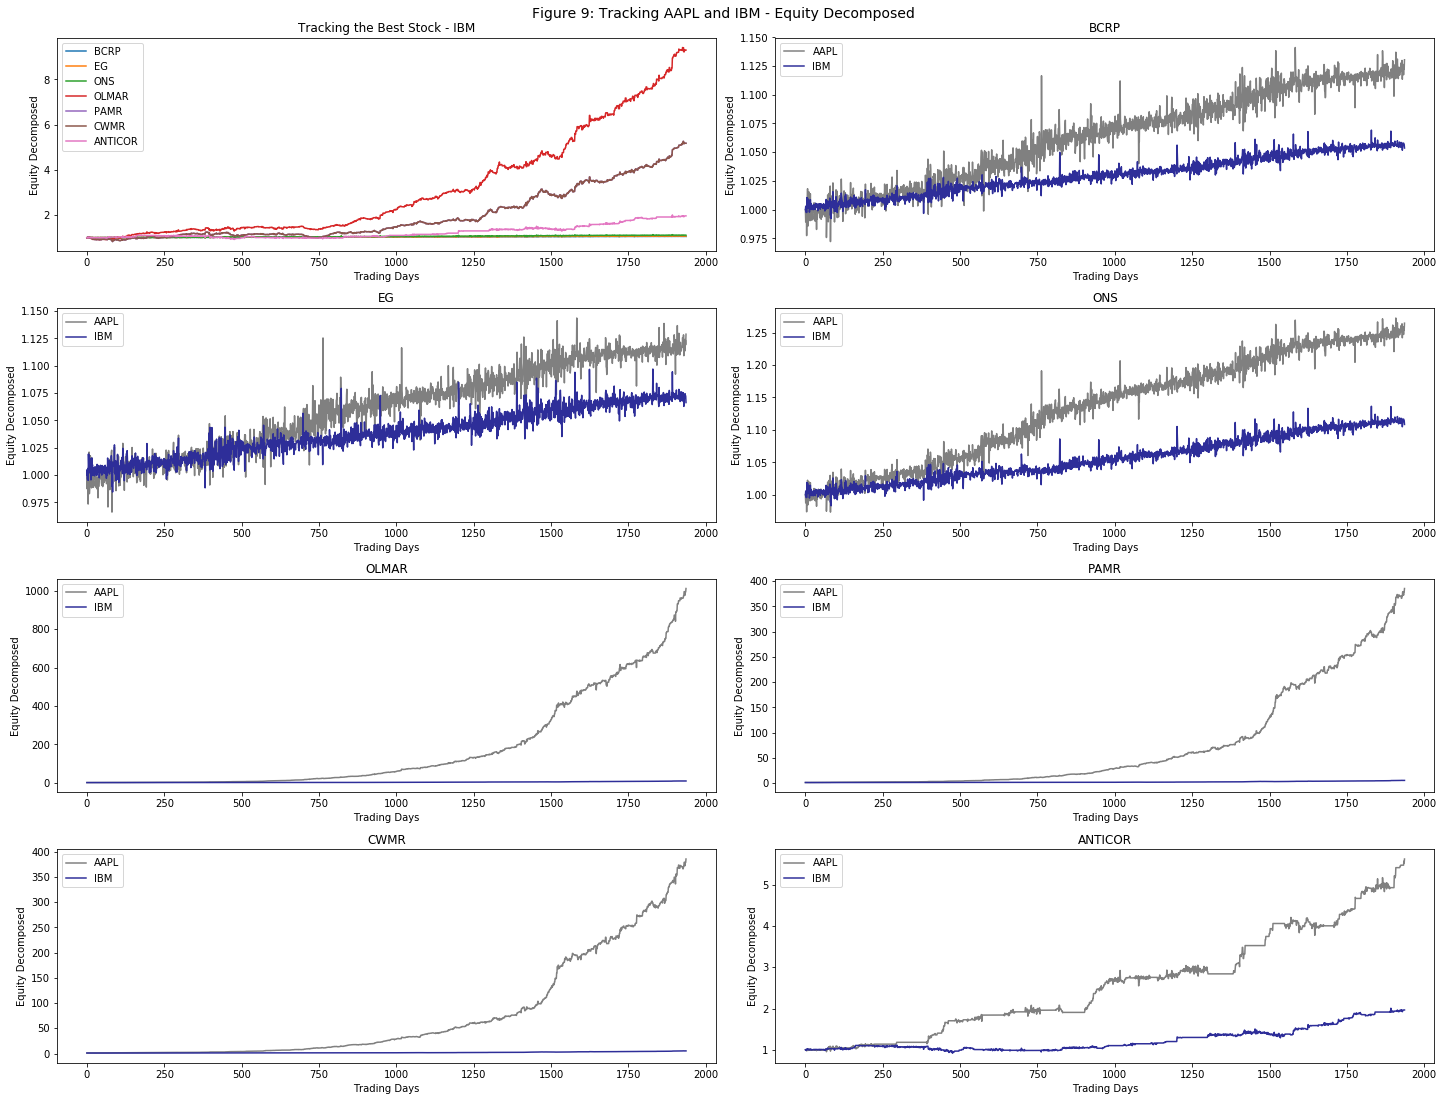

In [50]:
best_stock = 'IBM'
title = 'Figure 9: Tracking AAPL and IBM - Equity Decomposed'
colors = ['grey', sns.light_palette("navy", reverse=True)[1]]
figsize = (20,15)
plot_weights(exp5_df, 
             best_stock = best_stock,
            title = title,
            colors = colors, 
            figsize = figsize)

#### Notes: 
- Major drawback of follow the loser algorithms is clearly that they trade too often. We can include this for illustrative purposes 

#### Experiment 7: Annual Returns for High and Low Volatility Stocks 

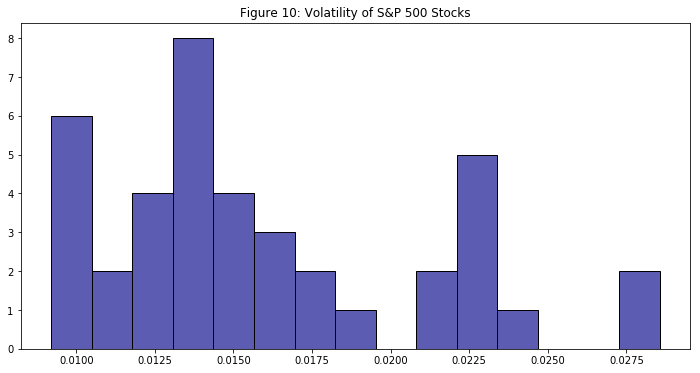

In [51]:
plt.figure(figsize = (12,6))
plt.hist(returns_df.std(axis = 0), bins = 15, ec = 'black', color = sns.light_palette("navy", reverse=True)[2])
plt.title('Figure 10: Volatility of S&P 500 Stocks')
plt.show()

In [52]:
### based on above histogram define a volatility threshold and partition data into high and low volatility data sets
n_stock = 10
high_vol = returns_df.loc[:,returns_df.std() > 0.02]
low_vol = returns_df.loc[:, returns_df.std() <= 0.0125]
low_vol = low_vol.iloc[:,0:n_stock]  # only need ten stocks in each data set 

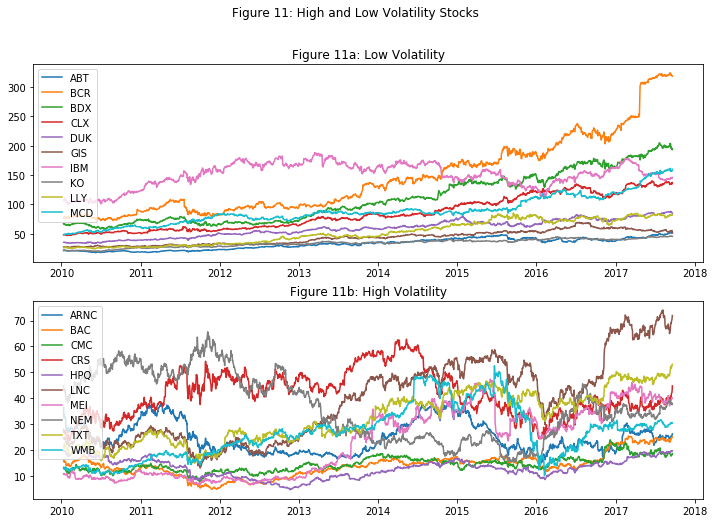

In [53]:
plt.figure(figsize = (12,8))
plt.suptitle('Figure 11: High and Low Volatility Stocks ')
plt.subplot(2,1,1)
plt.plot(price_df.loc[:, low_vol.columns])
plt.title('Figure 11a: Low Volatility')
plt.legend(low_vol.columns)
plt.subplot(2,1,2)
plt.plot(price_df.loc[:, high_vol.columns])
plt.title('Figure 11b: High Volatility')
plt.legend(high_vol.columns)
plt.show()

In [54]:
low_vol_res = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)
high_vol_res = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)

In [55]:
# run main for loop on low and high volatility data sets 
for i in range(len(algorithms_col)):
    low_vol_res.loc[algorithms_col[i], 'results'] = algorithms[i].run(low_vol)
    high_vol_res.loc[algorithms_col[i], 'results'] = algorithms[i].run(high_vol)

2017-12-09 17:35:20,089 Running BCRP...
2017-12-09 17:35:20,223 BCRP finished successfully.
2017-12-09 17:35:20,252 Running BCRP...
2017-12-09 17:35:20,380 BCRP finished successfully.
2017-12-09 17:35:20,407 Running EG...
2017-12-09 17:35:20,421 Progress: 0%...
2017-12-09 17:35:20,704 Progress: 10%...
2017-12-09 17:35:21,006 Progress: 20%...
2017-12-09 17:35:21,263 Progress: 30%...
2017-12-09 17:35:21,532 Progress: 40%...
2017-12-09 17:35:21,796 Progress: 50%...
2017-12-09 17:35:22,059 Progress: 60%...
2017-12-09 17:35:22,319 Progress: 70%...
2017-12-09 17:35:22,585 Progress: 80%...
2017-12-09 17:35:22,848 Progress: 90%...
2017-12-09 17:35:23,115 EG finished successfully.
2017-12-09 17:35:23,138 Running EG...
2017-12-09 17:35:23,154 Progress: 0%...
2017-12-09 17:35:23,430 Progress: 10%...
2017-12-09 17:35:23,697 Progress: 20%...
2017-12-09 17:35:23,967 Progress: 30%...
2017-12-09 17:35:24,239 Progress: 40%...
2017-12-09 17:35:24,502 Progress: 50%...
2017-12-09 17:35:24,783 Progress: 60

In [56]:
low_vol_res = statistics(low_vol_res)
high_vol_res = statistics(high_vol_res)

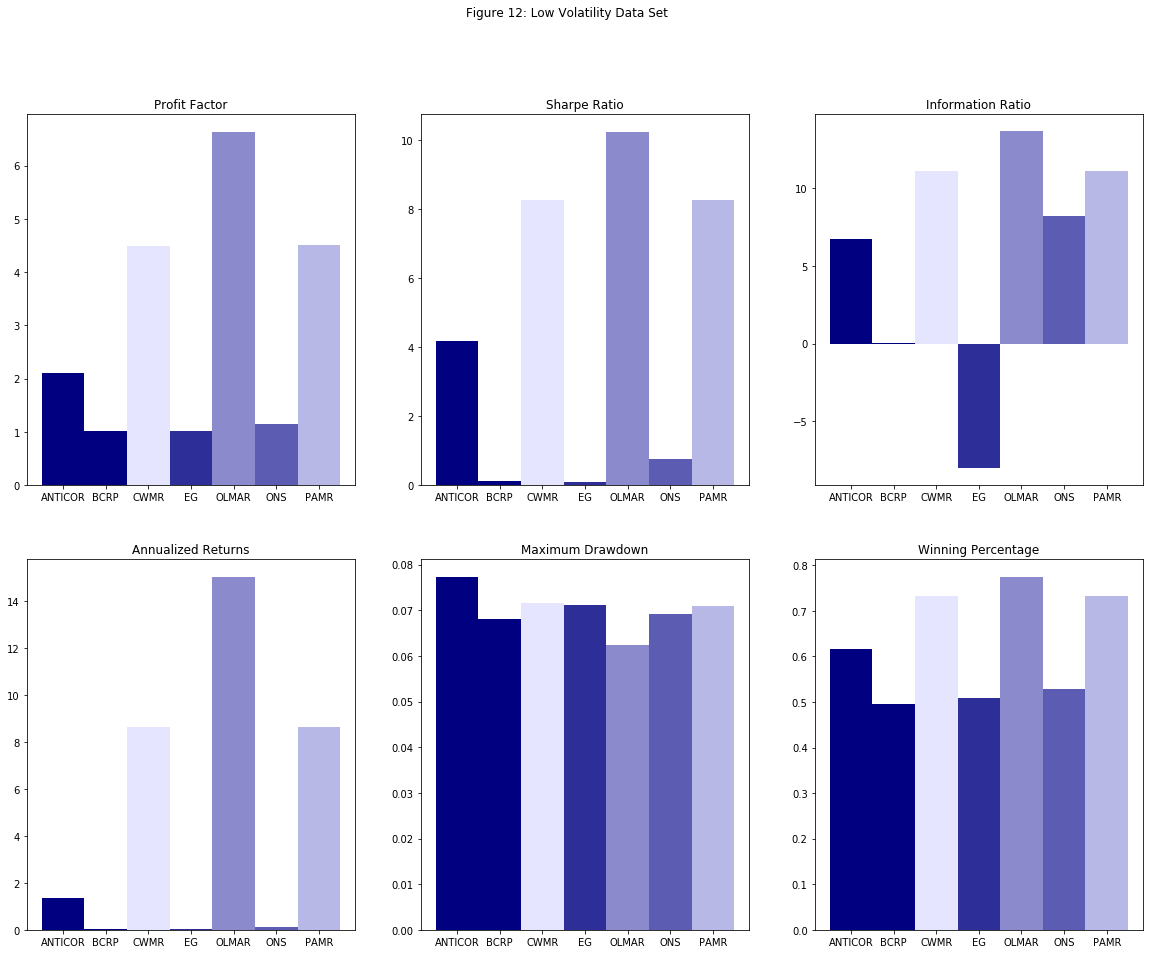

In [57]:
# plot results : low_vol_res, high_vol_res 
title = 'Figure 12: Low Volatility Data Set'
sub_title = ['Profit Factor', 
             'Sharpe Ratio', 
             'Information Ratio', 
             'Annualized Returns', 
             'Maximum Drawdown',
            'Winning Percentage']
results_plot(low_vol_res, title = title, sub_title = sub_title, figsize = (20,15))

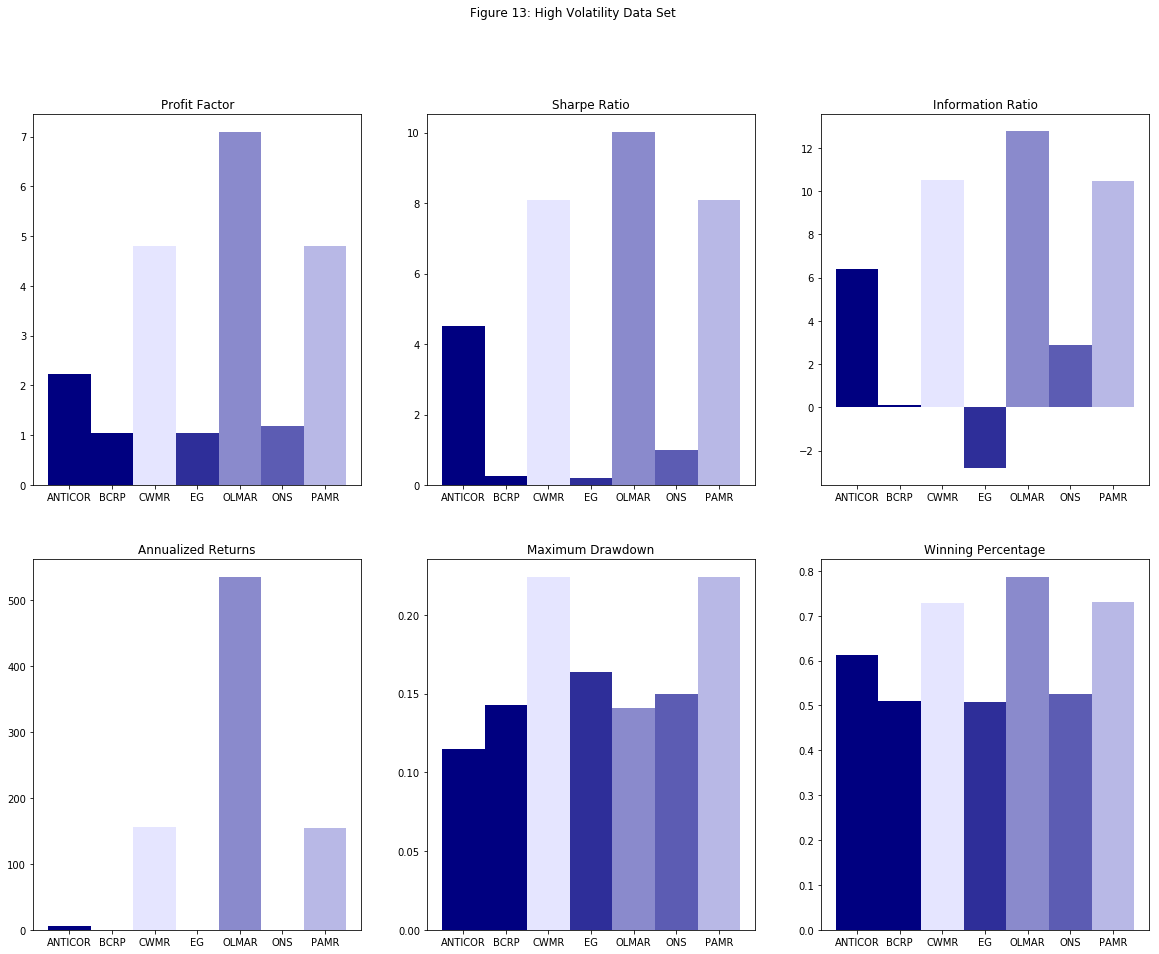

In [58]:
title = 'Figure 13: High Volatility Data Set'
sub_title = ['Profit Factor', 
             'Sharpe Ratio', 
             'Information Ratio', 
             'Annualized Returns', 
             'Maximum Drawdown',
            'Winning Percentage']
results_plot(high_vol_res, title = title, sub_title = sub_title, figsize = (20,15))